Cats Vs Dogs

In [2]:
%pip install torch
import numpy as np
import pandas as pd
import os
import random
import time

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd 
import os

Note: you may need to restart the kernel to use updated packages.


In [3]:
img_files = os.listdir('Petdata/train/')
img_files = list(filter(lambda x: x != 'train', img_files))
def train_path(p): return f"Petdata/train/{p}"
img_files = list(map(train_path, img_files))

print("total training images", len(img_files))
print("First item", img_files[0])



total training images 25000
First item E:/gis design huangbo/Cats-Vs-Dogs-CNN-using-Keras-/Kaggle/train/train/cat.0.jpg


In [4]:
# create train-test split
random.shuffle(img_files)

train = img_files[:20000]
test = img_files[20000:]

print("train size", len(train))
print("test size", len(test))


train size 20000
test size 5000


**Y and test_y as one hot array.**

**Preprocessing and collecting train and test data.**

In [5]:
# image normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# preprocessing of images
class CatDogDataset(Dataset):
    def __init__(self, image_paths, transform):
        super().__init__()
        self.paths = image_paths
        self.len = len(self.paths)
        self.transform = transform

    def __len__(self): return self.len

    def __getitem__(self, index): 
        path = self.paths[index]
        image = Image.open(path).convert('RGB')
        image = self.transform(image)
        label = 0 if 'cat' in path else 1
        return (image, label)


In [6]:
# create train dataset
train_ds = CatDogDataset(train, transform)
train_dl = DataLoader(train_ds, batch_size=100)
print(len(train_ds), len(train_dl))

# create test dataset
test_ds = CatDogDataset(test, transform)
test_dl = DataLoader(test_ds, batch_size=100)
print(len(test_ds), len(test_dl))


20000 200
5000 50


In [7]:
# Pytorch Convolutional Neural Network Model Architecture
class CatAndDogConvNet(nn.Module):

    def __init__(self):
        super().__init__()

        # onvolutional layers (3,16,32)
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size=(5, 5), stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size=(5, 5), stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size=(3, 3), padding=1)

        # conected layers
        self.fc1 = nn.Linear(in_features= 64 * 6 * 6, out_features=500)
        self.fc2 = nn.Linear(in_features=500, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=2)


    def forward(self, X):

        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2)

        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2)

        X = F.relu(self.conv3(X))
        X = F.max_pool2d(X, 2)

        X = X.view(X.shape[0], -1)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return X


In [26]:
# Create instance of the model
model = CatAndDogConvNet()

losses = []
accuracies = []

epoches = 8
start = time.time()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

# Model Training...
for epoch in range(epoches):

    epoch_loss = 0
    epoch_accuracy = 0

    for X, y in train_dl:

        preds = model(X)
        loss = loss_fn(preds, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        accuracy = ((preds.argmax(dim=1) == y).float().mean())
        epoch_accuracy += accuracy
        epoch_loss += loss
        print('.', end='', flush=True)

    epoch_accuracy = epoch_accuracy/len(train_dl)
    accuracies.append(epoch_accuracy)
    epoch_loss = epoch_loss / len(train_dl)
    losses.append(epoch_loss.detach().numpy())

    print("\n --- Epoch: {}, train loss: {:.4f}, train acc: {:.4f}, time: {}".format(epoch, epoch_loss, epoch_accuracy, time.time() - start))

    # test set accuracy
    with torch.no_grad():

        test_epoch_loss = 0
        test_epoch_accuracy = 0

        for test_X, test_y in test_dl:

            test_preds = model(test_X)
            test_loss = loss_fn(test_preds, test_y)

            test_epoch_loss += test_loss            
            test_accuracy = ((test_preds.argmax(dim=1) == test_y).float().mean())
            test_epoch_accuracy += test_accuracy
            accuracies.append(test_accuracy)

        test_epoch_accuracy = test_epoch_accuracy/len(test_dl)
        accuracies.append(test_epoch_accuracy.detach().numpy())
        test_epoch_loss = test_epoch_loss / len(test_dl)

        print("Epoch: {}, test loss: {:.4f}, test acc: {:.4f}, time: {}\n".format(epoch, test_epoch_loss, test_epoch_accuracy, time.time() - start))


........................................................................................................................................................................................................
 --- Epoch: 0, train loss: 0.6630, train acc: 0.5835, time: 146.22222089767456
Epoch: 0, test loss: 0.6285, test acc: 0.6302, time: 173.9490396976471

........................................................................................................................................................................................................
 --- Epoch: 1, train loss: 0.5452, train acc: 0.7198, time: 318.6189811229706
Epoch: 1, test loss: 0.5029, test acc: 0.7598, time: 346.3597619533539

........................................................................................................................................................................................................
 --- Epoch: 2, train loss: 0.4598, train acc: 0.7828, time: 490.8767457008362
Epoch: 2, test los

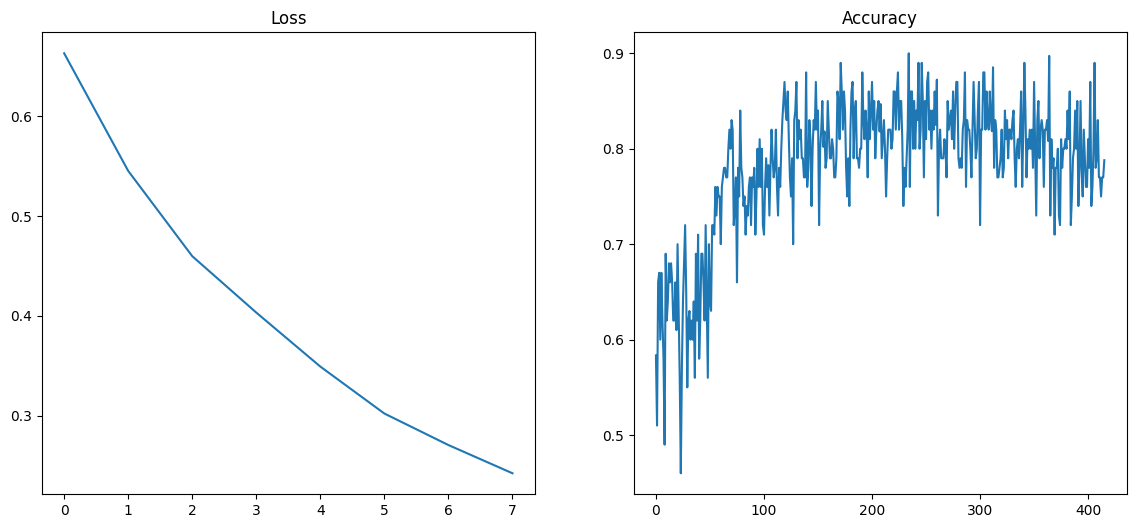

In [27]:
def plot_result():
     #Plot the result 
     plt.figure(figsize=(14,6)) 
     plt.subplot(121) 
     plt.plot(losses) 
     plt.title('Loss') 
     plt.subplot(122) 
     # plotting by columns 
     plt.plot(accuracies) 
     plt.title('Accuracy') 
     plt.show()

plot_result()